In [28]:
# import packages, set paths and create file lists

import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
import tifffile
import numpy as np
import os, glob

import pandas as pd

#import matplotlib.patches as patches
#%matplotlib inline


localroot = os.path.expanduser('~')

#citizen_science = os.path.join(localroot, '_FrancisCrickProject/CitizenScience/ROI_1656-6756-329')
manual = os.path.join(localroot, '_FrancisCrickProject/ROI_1656-6756-329_manual/')
microscopy = os.path.join(localroot, '_FrancisCrickProject/ROI_1656-6756-329/')

annotations = glob.glob(manual + '*.tif')
images = glob.glob(microscopy + '*.tif')

cnt_fnames = os.listdir(manual)
img_fnames = os.listdir(microscopy)

img_cont_pairs  = []

ref_im = None
ref_cont = None

# create image-contour pairs
for i in img_fnames:
    cont = [c for c in cnt_fnames if c[: c.index('.')] == i[:c.index('.')]]
    if len(cont) == 1:    
        img_cont_pairs.append((os.path.join(microscopy, i), \
                               os.path.join(manual, cont[0])))
    else:
        print (len(cont), 'found for image ', i, ' Check.')
    if '0090.tif' in i:
        ref_img = os.path.join(microscopy, i)
        ref_cont = os.path.join(manual, cont[0])

print 'found ', len(img_cont_pairs), ' image/contour pairs'

found  300  image/contour pairs


In [26]:
# texture analysis
import time

t0 = time.time()

SIZE = 11 # window size for texture calculation
IMAGE_SIZE = 2000

dissim = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
corr = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
contrast = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
#energy = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
homog = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
#asm = np.zeros((IMAGE_SIZE, IMAGE_SIZE))

for i, im_cont in enumerate(img_cont_pairs):
    # For this example, only work with image *_z0090.tif'
    if '0090.tif' not in im_cont[0]:
        continue
        
    im = tifffile.imread(im_cont[0])
    #im = im[1000:1100, 1000:1100]
    offset = int(np.floor(SIZE/2))
    # pad image by 1/2 patch size
    im = np.pad(im, pad_width=(offset, offset), mode='reflect') 
        
    print 'new image dimensions', im.shape
    
    
    # iterate through updated image dimensions
    for ix in range(offset, im.shape[0] - offset):
        for iy in range(offset, im.shape[1] - offset):
            try:
                patch = im[ix - offset : ix + offset, iy - offset : iy + offset] 
                glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
                
                # save into the matrix with original image dimensions
                dissim[ix - offset, iy - offset] = greycoprops(glcm, 'dissimilarity')[0, 0]
                corr[ix - offset, iy - offset] = greycoprops(glcm, 'correlation')[0, 0]
                contrast[ix - offset, iy - offset] = greycoprops(glcm, 'contrast')[0, 0]
                # energy and asm were not very predictive in text runs
                #energy[ix - offset, iy - offset] = greycoprops(glcm, 'energy')[0, 0]
                #asm[ix - offset, iy - offset] = greycoprops(glcm, 'ASM')[0, 0]
                homog[ix - offset, iy - offset] = greycoprops(glcm, 'homogeneity')[0, 0]
            except IndexError:
                print 'ix', ix, 'iy', iy

                

tN = time.time()
print 'time for 10000 px', tN - t0, 'seconds'


#import matplotlib.pyplot as plt
#%matplotlib inline

#plt.imshow(homog[:100, 0:100])
#plt.imshow(dissim[:100, 0:100])
# energy & asm bad
df = pd.DataFrame(homog)
df.to_csv('/home/marina/_FrancisCrickProject/features/homog.csv', index=False, compression='gzip')

df = pd.DataFrame(corr)
df.to_csv('/home/marina/_FrancisCrickProject/features/correlation.csv', index=False, compression='gzip')

df = pd.DataFrame(dissim)
df.to_csv('/home/marina/_FrancisCrickProject/features/dissimilarity.csv', index=False, compression='gzip')

df = pd.DataFrame(contrast)
df.to_csv('/home/marina/_FrancisCrickProject/features/contrast.csv', index=False, compression='gzip')


# 96 kB gzipped, 15.4 MB unzipped


new image dimensions (2010, 2010)


KeyboardInterrupt: 

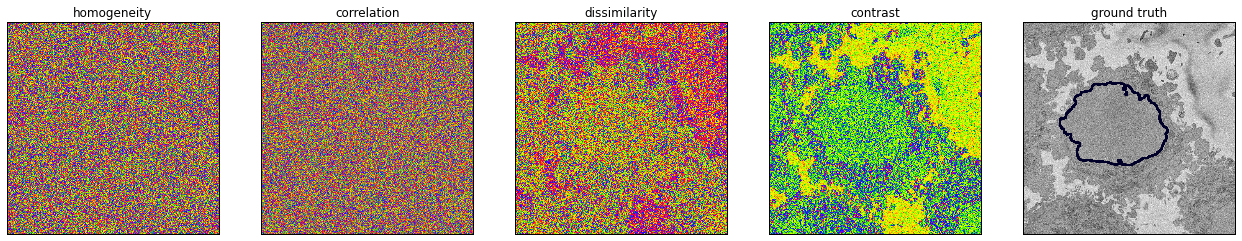

In [43]:
%matplotlib inline

filenames = ['homog.csv', 'correlation.csv', 'dissimilarity.csv', 'contrast.csv']
labels = ['homogeneity', 'correlation', 'dissimilarity', 'contrast']
folder = '/home/marina/_FrancisCrickProject/features/'
paths = [folder + f for f in filenames]

#print ref_cont
cn = tifffile.imread(ref_cont)
cn = np.nonzero(cn > 1)
cn = (cn[1], cn[0])

fig, axx = plt.subplots(1, 5, figsize=(22, 10))

for i, a in enumerate(axx[:-1]):
    a.imshow(pd.read_csv(paths[i], compression='gzip'), cmap='prism')
    a.set_title(labels[i])
    a.set_xticks([])
    a.set_yticks([])



axx[4].plot(cn[0], cn[1], 'bo', markersize=0.5)
axx[4].imshow(im, cmap='gray')
axx[4].set_title('ground truth')
axx[4].set_xticks([])
axx[4].set_yticks([])

fig.savefig(folder + 'texture_features.png', dpi = 100, bbox_inches='tight')

(2000, 2000)


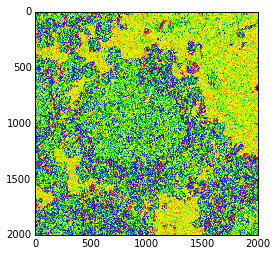

In [53]:
df = pd.read_csv(paths[3], compression='gzip')
print df.shape

# plot dataframe as is ...
plt.imshow(df)

# ... or convert it to numpy array
nparr = df.as_matrix()
plt.imshow(nparr, cmap='prism')
